<a href="https://colab.research.google.com/github/AkhandSingh96/Stock-Market-Prediction-Using-Deep-Learning-/blob/main/StockRNNipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the required libraries.


In [13]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, GRU
from keras.optimizers import SGD
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, GRU
from keras.optimizers import SGD
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [2]:
!pip install yahoofinancials
!pip install yfinance

  Created wheel for yahoofinancials: filename=yahoofinancials-1.6-cp37-none-any.whl size=15192 sha256=420e70792d61a338c3397ce1b99f17eb8c4bed989bd8ea880b92525152c3eeef
  Stored in directory: /root/.cache/pip/wheels/d9/7e/cf/4977a8572d5247242a4b13018d1d36923024ba84236e0d28bc
Successfully built yahoofinancials
     |████████████████████████████████| 6.3MB 3.2MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23442 sha256=2e079e5850cf0d651a79123b372f98e6416c6c8d9ee97178319fac9d0ab42c96
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


# Preparing and preprocessing the dataset.

In [3]:
import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials

AMZN = yf.download('AMZN', start='2013-01-01', end='2019-12-31',progress=False)
all_data = AMZN[['Adj Close','Open', 'High', 'Low', 'Close', 'Volume']].round(2)
all_data.head(10)

,Adj Close,Open,High,Low,Close,Volume
Date,,,,,,
2013-01-02,257.31,256.08,258.10,253.26,257.31,3271000
2013-01-03,258.48,257.27,260.88,256.37,258.48,2750900
2013-01-04,259.15,257.58,259.80,256.65,259.15,1874200
2013-01-07,268.46,262.97,269.73,262.67,268.46,4910000
2013-01-08,266.38,267.07,268.98,263.57,266.38,3010700
2013-01-09,266.35,268.17,269.50,265.40,266.35,2265600
2013-01-10,265.34,268.54,268.74,262.30,265.34,2863400
2013-01-11,267.94,265.10,268.43,264.11,267.94,2413300
2013-01-14,272.73,268.00,274.26,267.54,272.73,4275000


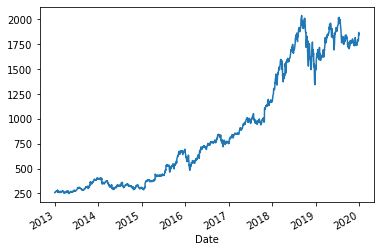

In [4]:
all_data['Adj Close'].plot()

In [5]:
print("There are "+ str(all_data[:'2018'].shape[0]) + " observations in the training data")
print("There are "+ str(all_data['2019':].shape[0]) + " observations in the test data")

There are 1510 observations in the training data
There are 251 observations in the test data


Function for splitting the dataset.

In [14]:
def train_test_split(all_data,time_steps,for_periods):
    
    train = all_data[:'2018'].iloc[:,0:1].values
    test  = all_data['2019':].iloc[:,0:1].values
    train_len = len(train)
    test_len = len(test)

    
    X_train = []
    y_train = []
    X_train_stacked = []
    for i in range(time_steps,train_len-1): 
        X_train.append(train[i-time_steps:i,0])
        y_train.append(train[i:i+for_periods,0])
    X_train, y_train = np.array(X_train), np.array(y_train)

 
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    inputs = pd.concat((all_data["Adj Close"][:'2018'], all_data["Adj Close"]['2019':]),axis=0).values
    inputs = inputs[len(inputs)-len(test) - time_steps:]
    inputs = inputs.reshape(-1,1)

  
    X_test = []
    for i in range(time_steps,test_len+time_steps-for_periods):
        X_test.append(inputs[i-time_steps:i,0])
        
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return X_train, y_train , X_test

X_train, y_train, X_test = train_test_split(all_data,5,2)
X_train.shape[0],X_train.shape[1]

(1504, 5)

In [15]:
X_train_see = pd.DataFrame(np.reshape(X_train, (X_train.shape[0],X_train.shape[1])))
y_train_see = pd.DataFrame(y_train)
pd.concat([X_train_see,y_train_see],axis=1)

,0,1,2,3,4,0,1
0,257.31,258.48,259.15,268.46,266.38,266.35,265.34
1,258.48,259.15,268.46,266.38,266.35,265.34,267.94
2,259.15,268.46,266.38,266.35,265.34,267.94,272.73
3,268.46,266.38,266.35,265.34,267.94,272.73,271.90
4,266.38,266.35,265.34,267.94,272.73,271.90,268.93
...,...,...,...,...,...,...,...
1499,1591.91,1520.91,1551.48,1495.08,1460.83,1377.45,1343.96
1500,1520.91,1551.48,1495.08,1460.83,1377.45,1343.96,1470.90
1501,1551.48,1495.08,1460.83,1377.45,1343.96,1470.90,1461.64
1502,1495.08,1460.83,1377.45,1343.96,1470.90,1461.64,1478.02


In [16]:
X_test_see = pd.DataFrame(np.reshape(X_test, (X_test.shape[0],X_test.shape[1])))
pd.DataFrame(X_test_see)

,0,1,2,3,4
0,1343.96,1470.90,1461.64,1478.02,1501.97
1,1470.90,1461.64,1478.02,1501.97,1539.13
2,1461.64,1478.02,1501.97,1539.13,1500.28
3,1478.02,1501.97,1539.13,1500.28,1575.39
4,1501.97,1539.13,1500.28,1575.39,1629.51
...,...,...,...,...,...
244,1760.33,1760.94,1769.21,1790.66,1784.03
245,1760.94,1769.21,1790.66,1784.03,1792.28
246,1769.21,1790.66,1784.03,1792.28,1786.50
247,1790.66,1784.03,1792.28,1786.50,1793.00


In [17]:
print("There are " + str(X_train.shape[0]) + " samples in the training data")
print("There are " + str(X_test.shape[0]) + " samples in the test data")

There are 1504 samples in the training data
There are 249 samples in the test data


##Building the simple RNN model.

In [18]:
def rnn_model(X_train, y_train, X_test):
    
    
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN
    
    rnn_model = Sequential()
    rnn_model.add(SimpleRNN(32, return_sequences=True))
    
    rnn_model.add(SimpleRNN(32))
    rnn_model.add(Dense(2))

    rnn_model.compile(optimizer='rmsprop', loss='mean_squared_error')

    
    rnn_model.fit(X_train, y_train, epochs=100, batch_size=150, verbose=0)

   
    rnn_predictions = rnn_model.predict(X_test)

    return rnn_model, rnn_predictions

rnn_model, rnn_predictions = rnn_model(X_train, y_train, X_test)
rnn_predictions[1:10]

array([[41.560017, 40.789692],
       [41.560017, 40.789692],
       [41.560017, 40.789692],
       [41.560017, 40.789692],
       [41.560017, 40.789692],
       [41.560017, 40.789692],
       [41.560017, 40.789692],
       [41.560017, 40.789692],
       [41.560017, 40.789692]], dtype=float32)

(3061736.2, <matplotlib.axes._subplots.AxesSubplot at 0x7f1ba4190ad0>)

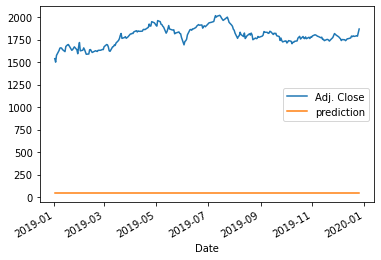

In [21]:
def pred_plot(preds):
    actual_pred = pd.DataFrame(columns = ['Adj. Close', 'prediction'])
    actual_pred['Adj. Close'] = all_data.loc['2019':,'Adj Close'][0:len(preds)]
    actual_pred['prediction'] = preds[:,0]

    from keras.metrics import MeanSquaredError
    m = MeanSquaredError()
    m.update_state(np.array(actual_pred['Adj. Close']),np.array(actual_pred['prediction']))
    
    return (m.result().numpy(), actual_pred.plot() )
 
pred_plot(rnn_predictions)

(4711.7007, <matplotlib.axes._subplots.AxesSubplot at 0x7f1ba1839f50>)

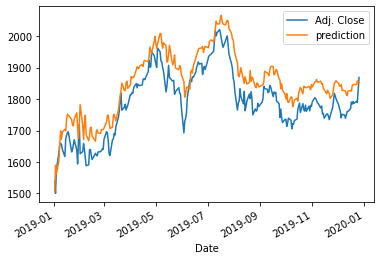

In [25]:
def train_test_normalize(all_data,time_steps,for_periods):


    sc = MinMaxScaler(feature_range=(0,1))
    train = all_data[:'2018'].iloc[:,0:1].values
    test  = all_data['2019':].iloc[:,0:1].values


    train_len = len(train)
    test_len = len(test)

    
    train_scaled = sc.fit_transform(train)

    X_train = []
    y_train = []
    y_train_stacked = []

    for i in range(time_steps,train_len-1): 
        X_train.append(train_scaled[i-time_steps:i,0])
        y_train.append(train_scaled[i:i+for_periods,0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    inputs = pd.concat((all_data["Adj Close"][:'2018'], all_data["Adj Close"]['2019':]),axis=0).values
    inputs = inputs[len(inputs)-len(test) - time_steps:]
    inputs = inputs.reshape(-1,1)
    inputs  = sc.transform(inputs)

    X_test = []
    for i in range(time_steps,test_len+time_steps-for_periods):
        X_test.append(inputs[i-time_steps:i,0])
        
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return X_train, y_train , X_test, sc

def rnn_model(X_train, y_train, X_test, sc):
    
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN
    
    my_rnn_model = Sequential()
    my_rnn_model.add(SimpleRNN(32, return_sequences=True))
  
    my_rnn_model.add(SimpleRNN(32))
    my_rnn_model.add(Dense(2))

    my_rnn_model.compile(optimizer='rmsprop', loss='mean_squared_error')

    my_rnn_model.fit(X_train, y_train, epochs=100, batch_size=150, verbose=0)

    rnn_predictions = my_rnn_model.predict(X_test)
    from sklearn.preprocessing import MinMaxScaler
    rnn_predictions = sc.inverse_transform(rnn_predictions)

    return my_rnn_model, rnn_predictions


X_train, y_train, X_test, sc = train_test_normalize(all_data,5,2)
my_rnn_model, rnn_predictions_2 =rnn_model(X_train, y_train, X_test, sc)
rnn_predictions_2[1:10]
pred_plot(rnn_predictions_2)

(56861.945, <matplotlib.axes._subplots.AxesSubplot at 0x7f1ba35b5f50>)

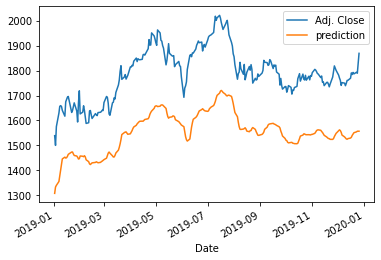

In [26]:
def GRU_model(X_train, y_train, X_test, sc):
    

    
    GRU_model = Sequential()
    
    GRU_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    
    GRU_model.add(GRU(units=50, activation='tanh'))
    GRU_model.add(Dense(units=2))

    
    GRU_model.compile(optimizer=SGD(lr=0.001, decay=1e-4, momentum=0.9, nesterov=False),loss='mean_squared_error')
    
    GRU_model.fit(X_train,y_train,epochs=50,batch_size=150, verbose=0)

    GRU_prediction = GRU_model.predict(X_test)
    GRU_prediction = sc.inverse_transform(GRU_prediction)

    return GRU_model, GRU_prediction

model, prediction = GRU_model(X_train, y_train, X_test, sc)
prediction[1:10]
pred_plot(prediction)

(3349.2595, <matplotlib.axes._subplots.AxesSubplot at 0x7f1ba4f74bd0>)

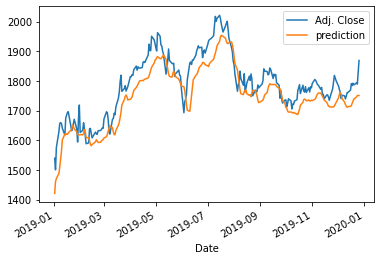

In [30]:
def GRU_model_regularization(X_train, y_train, X_test, sc):

  
    GRU_model = Sequential()
    
    GRU_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    GRU_model.add(Dropout(0.2))
  
    GRU_model.add(GRU(units=50, return_sequences=True, activation='tanh'))
    GRU_model.add(Dropout(0.2))
    
    GRU_model.add(GRU(units=50, return_sequences=True, activation='tanh'))
    GRU_model.add(Dropout(0.2))

    GRU_model.add(GRU(units=50, activation='tanh'))
    GRU_model.add(Dropout(0.2))
    
    GRU_model.add(Dense(units=1))

    GRU_model.compile(optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.8, nesterov=False),loss='mean_squared_error')

    GRU_model.fit(X_train,y_train,epochs=50,batch_size=150, verbose=0)

    GRU_predictions = GRU_model.predict(X_test)
    GRU_predictions = sc.inverse_transform(GRU_predictions)

    return GRU_model, GRU_predictions

GRU_model, GRU_predictions = GRU_model_regularization(X_train, y_train, X_test, sc)
GRU_predictions[1:10]
pred_plot(GRU_predictions)